# Implementation of prophet time series forecasting for case arrivals

In [1]:
import pandas as pd
from prophet import Prophet

Importing plotly failed. Interactive plots will not work.


In [2]:
df = pd.read_csv('./CaseArrivalCountsApril.csv')
#df = df[df['day'] > '2023-01-01']
df['day'] = pd.to_datetime(df['day'], utc=True)
df['day'] = df['day'].dt.date
df['day'] = df['day'] + pd.Timedelta(days=1)
df.rename(columns={'day': 'ds', 'event_count': 'y'}, inplace=True)

df.head(10)

FileNotFoundError: [Errno 2] No such file or directory: './CaseArrivalCountsApril.csv'

In [32]:
Q1 = df['y'].quantile(0.10)
Q3 = df['y'].quantile(0.90)
IQR = Q3 - Q1

lower_bound = max(df['y'].quantile(0.05), Q1 - 1.5 * IQR)
upper_bound = Q3 + 1.5 * IQR

df_cleaned = df[(df['y'] >= lower_bound) & (df['y'] <= upper_bound)]


In [33]:
import pandas as pd
import holidays
from prophet import Prophet

df_cleaned['ds'] = pd.to_datetime(df_cleaned['ds'])

spike_period = pd.DataFrame({
    'holiday': 'spike_event',
    'ds': pd.date_range(start='2022-04-01', end='2022-11-01')
})

years = list(df_cleaned['ds'].dt.year.unique())
years = sorted(set(years + [2022]))
no_holidays = holidays.CountryHoliday('NO', years=years)

norway_df = (
    pd.DataFrame([
        {'ds': pd.to_datetime(d), 'holiday': name}
        for d, name in no_holidays.items()
    ])
)

print(norway_df.head())

all_holidays = pd.concat([norway_df, spike_period], ignore_index=True)

m = Prophet(
    interval_width=0.90,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.2,
    holidays=all_holidays
)
m.fit(df_cleaned)


C:\Users\Mikke\AppData\Local\Temp\ipykernel_70828\3957155616.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['ds'] = pd.to_datetime(df_cleaned['ds'])


          ds          holiday
0 2020-01-01   New Year's Day
1 2020-04-09  Maundy Thursday
2 2020-04-10      Good Friday
3 2020-04-12    Easter Sunday
4 2020-04-13    Easter Monday


18:03:25 - cmdstanpy - INFO - Chain [1] start processing
18:03:26 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
future = m.make_future_dataframe(periods=300)

future = future[~future['ds'].dt.dayofweek.isin([5, 6])]

future = future.reset_index(drop=True)

future.tail()

,ds
1267,2026-01-22
1268,2026-01-23
1269,2026-01-26
1270,2026-01-27
1271,2026-01-28


In [35]:

forecast = m.predict(future)
# Ensure predictions are not less than 0
forecast['yhat'] = forecast['yhat'].clip(lower=0)
forecast['yhat_lower'] = forecast['yhat_lower'].clip(lower=0)
forecast['yhat_upper'] = forecast['yhat_upper'].clip(lower=0)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('forecastApril.csv')



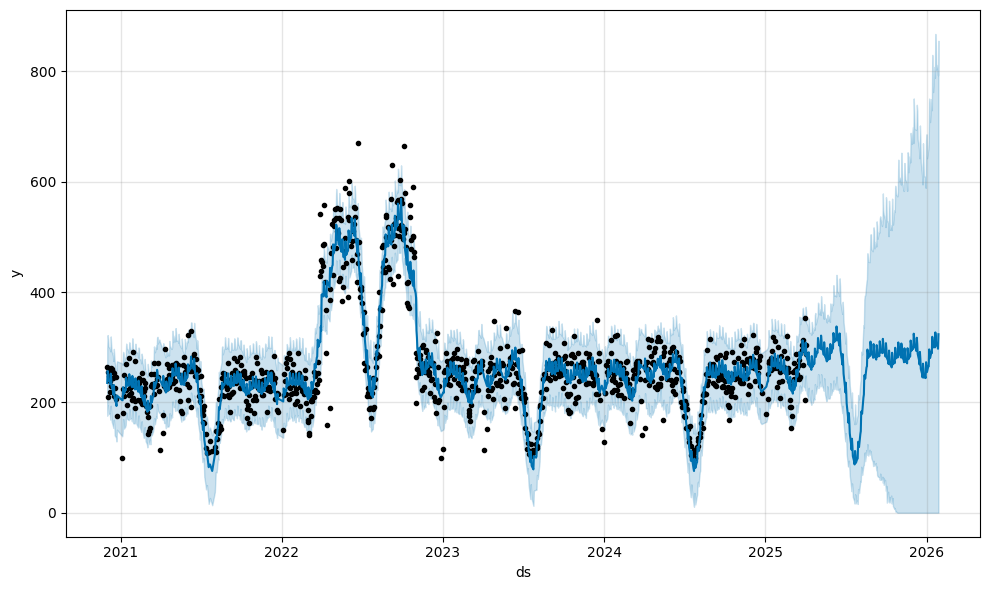

In [36]:
fig1 = m.plot(forecast)


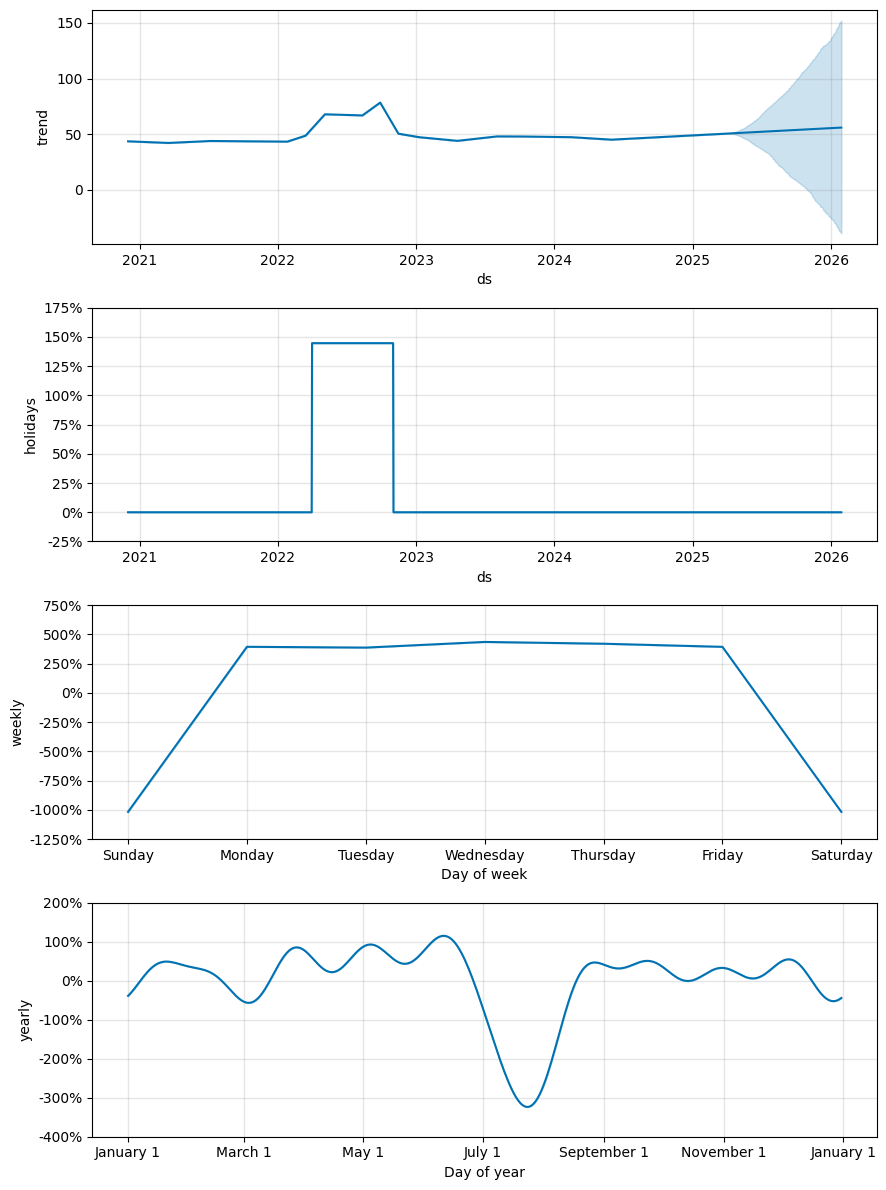

In [37]:
fig2 = m.plot_components(forecast)


In [38]:
from prophet.diagnostics import cross_validation, performance_metrics


In [ ]:
df_cv = cross_validation(m, initial='1000 days', period='100 days', horizon='70 days')

df_metrics = performance_metrics(df_cv)
print(df_metrics)


  0%|          | 0/6 [00:00<?, ?it/s]

18:03:48 - cmdstanpy - INFO - Chain [1] start processing
18:03:49 - cmdstanpy - INFO - Chain [1] done processing
18:03:50 - cmdstanpy - INFO - Chain [1] start processing
18:03:51 - cmdstanpy - INFO - Chain [1] done processing
18:03:51 - cmdstanpy - INFO - Chain [1] start processing


timedelta64[ns]


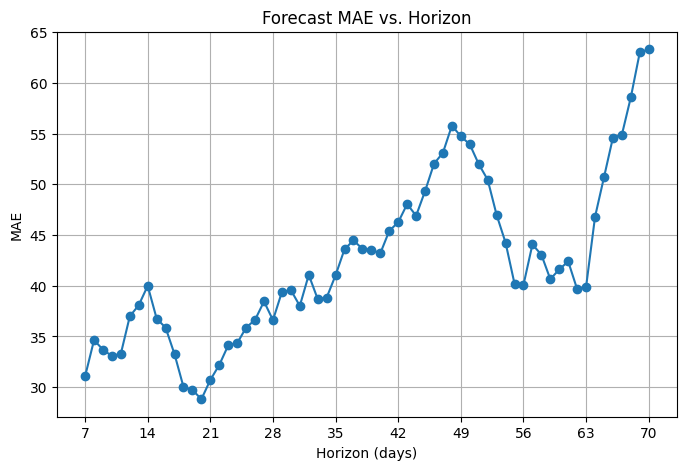

In [29]:
# confirm its type
print(df_metrics['horizon'].dtype)    # should be timedelta64[ns]

# create a plain-integer days column
df_metrics['horizon_days'] = df_metrics['horizon'].dt.days

# now plot against that
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(df_metrics['horizon_days'], df_metrics['mae'], marker='o')
plt.xlabel('Horizon (days)')
plt.ylabel('MAE')
plt.title('Forecast MAE vs. Horizon')
plt.xticks(df_metrics['horizon_days'][::7])   # e.g. label every 7th day
plt.grid(True)
plt.show()


In [22]:
import itertools
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# df = pd.read_csv('./correct_case_arrivals.csv')
# ... (date conversion, outlier removal, etc.)
# df_cleaned = df[(df['y'] >= lower_bound) & (df['y'] <= upper_bound)]

param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.05, 0.1, 0.5, 1.0, 5, 10.0]
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

results = []

for params in all_params:
    print("Testing parameters:", params)
    
    m = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode= 'multiplicative'
    )
    

    # m.add_regressor('floor')
    
    m.fit(df_cleaned)
    

    df_cv = cross_validation(m, initial='100 days', period='30 days', horizon='15 days')
    
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    avg_rmse = df_p['mse'].mean()
    
    result = params.copy()
    result['mse'] = avg_rmse
    results.append(result)

results_df = pd.DataFrame(results).sort_values(by='mse')
print("Hyperparameter Tuning Results:")
print(results_df)


14:36:08 - cmdstanpy - INFO - Chain [1] start processing


Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01}


14:36:08 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing
14:36:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:36:09 - cmdstanpy - INFO - Chain [1] start processing
14:36:09 - cmdstanpy - INFO - Chain [1] done processing
14:36:10 - cmdstanpy - INFO - Chain [1] start processing
14:36:10 - cmdstanpy - INFO - Chain [1] done processing
14:36:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:36:10 - cmdstanpy - INFO - Chain [1] start processing
14:36:11 - cmdstanpy - INFO - Chain [1] done processing
14:36:11 - cmdstanpy - INFO - Chain [1] start processing
14:36:11 - cmdstanpy - INFO - Chain [1] done processing
14:36:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.05}


14:36:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:36:33 - cmdstanpy - INFO - Chain [1] start processing
14:36:33 - cmdstanpy - INFO - Chain [1] done processing
14:36:33 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:36:33 - cmdstanpy - INFO - Chain [1] start processing
14:36:34 - cmdstanpy - INFO - Chain [1] done processing
14:36:34 - cmdstanpy - INFO - Chain [1] start processing
14:36:34 - cmdstanpy - INFO - Chain [1] done processing
14:36:34 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:36:34 - cmdstanpy - INFO - Chain [1] start processing
14:36:35 - cmdstanpy - INFO - Chain [1] done processing
14:36:35 - cmdstanpy - INFO - Chain [1] start processing
14:36:35 - cmdstanpy - INFO - Chain [1] done processing
14:36:35 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1}


14:36:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:36:56 - cmdstanpy - INFO - Chain [1] start processing
14:36:56 - cmdstanpy - INFO - Chain [1] done processing
14:36:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:36:56 - cmdstanpy - INFO - Chain [1] start processing
14:36:57 - cmdstanpy - INFO - Chain [1] done processing
14:36:57 - cmdstanpy - INFO - Chain [1] start processing
14:36:57 - cmdstanpy - INFO - Chain [1] done processing
14:36:57 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:36:57 - cmdstanpy - INFO - Chain [1] start processing
14:36:59 - cmdstanpy - INFO - Chain [1] done processing
14:36:59 - cmdstanpy - INFO - Chain [1] start processing
14:36:59 - cmdstanpy - INFO - Chain [1] done processing
14:36:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.5}


14:37:21 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:37:21 - cmdstanpy - INFO - Chain [1] start processing
14:37:21 - cmdstanpy - INFO - Chain [1] done processing
14:37:21 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:37:21 - cmdstanpy - INFO - Chain [1] start processing
14:37:22 - cmdstanpy - INFO - Chain [1] done processing
14:37:23 - cmdstanpy - INFO - Chain [1] start processing
14:37:23 - cmdstanpy - INFO - Chain [1] done processing
14:37:23 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:37:23 - cmdstanpy - INFO - Chain [1] start processing
14:37:24 - cmdstanpy - INFO - Chain [1] done processing
14:37:24 - cmdstanpy - INFO - Chain [1] start processing
14:37:24 - cmdstanpy - INFO - Chain [1] done processing
14:37:24 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0}


14:37:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:37:47 - cmdstanpy - INFO - Chain [1] start processing
14:37:47 - cmdstanpy - INFO - Chain [1] done processing
14:37:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:37:47 - cmdstanpy - INFO - Chain [1] start processing
14:37:49 - cmdstanpy - INFO - Chain [1] done processing
14:37:49 - cmdstanpy - INFO - Chain [1] start processing
14:37:49 - cmdstanpy - INFO - Chain [1] done processing
14:37:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:37:49 - cmdstanpy - INFO - Chain [1] start processing
14:37:50 - cmdstanpy - INFO - Chain [1] done processing
14:37:50 - cmdstanpy - INFO - Chain [1] start processing
14:37:50 - cmdstanpy - INFO - Chain [1] done processing
14:37:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 5}


14:38:15 - cmdstanpy - INFO - Chain [1] start processing
14:38:15 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:38:15 - cmdstanpy - INFO - Chain [1] start processing
14:38:15 - cmdstanpy - INFO - Chain [1] done processing
14:38:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:38:15 - cmdstanpy - INFO - Chain [1] start processing
14:38:17 - cmdstanpy - INFO - Chain [1] done processing
14:38:17 - cmdstanpy - INFO - Chain [1] start processing
14:38:17 - cmdstanpy - INFO - Chain [1] done processing
14:38:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:38:17 - cmdstanpy - INFO - Chain [1] start processing
14:38:18 - cmdstanpy - INFO - Chain [1] done processing
14:38:18 - cmdstanpy - INFO - Chain [1] start processing
14:38:18 - cmdstanpy - INFO - Chain [1] done processing
14:38:18 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Testing parameters: {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0}


14:38:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:38:43 - cmdstanpy - INFO - Chain [1] start processing
14:38:43 - cmdstanpy - INFO - Chain [1] done processing
14:38:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:38:44 - cmdstanpy - INFO - Chain [1] start processing
14:38:44 - cmdstanpy - INFO - Chain [1] done processing
14:38:44 - cmdstanpy - INFO - Chain [1] start processing
14:38:45 - cmdstanpy - INFO - Chain [1] done processing
14:38:45 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
14:38:45 - cmdstanpy - INFO - Chain [1] start processing
14:38:45 - cmdstanpy - INFO - Chain [1] done processing
14:38:46 - cmdstanpy - INFO - Chain [1] start processing
14:38:46 - cmdstanpy - INFO - Chain [1] done processing
14:38:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}


14:39:11 - cmdstanpy - INFO - Chain [1] start processing
14:39:11 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:39:11 - cmdstanpy - INFO - Chain [1] start processing
14:39:11 - cmdstanpy - INFO - Chain [1] done processing
14:39:12 - cmdstanpy - INFO - Chain [1] start processing
14:39:12 - cmdstanpy - INFO - Chain [1] done processing
14:39:12 - cmdstanpy - INFO - Chain [1] start processing
14:39:12 - cmdstanpy - INFO - Chain [1] done processing
14:39:12 - cmdstanpy - INFO - Chain [1] start processing
14:39:12 - cmdstanpy - INFO - Chain [1] done processing
14:39:12 - cmdstanpy - INFO - Chain [1] start processing
14:39:12 - cmdstanpy - INFO - Chain [1] done processing
14:39:13 - cmdstanpy - INFO - Chain [1] start processing
14:39:13 - cmdstanpy - INFO - Chain [1] done processing
14:39:13 - cmdstanpy - INFO - Chain [1] start processing
14:39:13 - cmdstanpy - INFO - Chain [1] done processing
14:39:13 - cmdstanpy - INFO - Chain [1] start processing
14:39:13 - cmdstanpy - INFO - Chain [1] done processing
14:39:13 - cmdstanpy - INFO - Chain [1] start processing
14:39:14 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.05}


14:39:22 - cmdstanpy - INFO - Chain [1] start processing
14:39:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:39:22 - cmdstanpy - INFO - Chain [1] start processing
14:39:22 - cmdstanpy - INFO - Chain [1] done processing
14:39:22 - cmdstanpy - INFO - Chain [1] start processing
14:39:22 - cmdstanpy - INFO - Chain [1] done processing
14:39:23 - cmdstanpy - INFO - Chain [1] start processing
14:39:23 - cmdstanpy - INFO - Chain [1] done processing
14:39:23 - cmdstanpy - INFO - Chain [1] start processing
14:39:23 - cmdstanpy - INFO - Chain [1] done processing
14:39:23 - cmdstanpy - INFO - Chain [1] start processing
14:39:23 - cmdstanpy - INFO - Chain [1] done processing
14:39:23 - cmdstanpy - INFO - Chain [1] start processing
14:39:24 - cmdstanpy - INFO - Chain [1] done processing
14:39:24 - cmdstanpy - INFO - Chain [1] start processing
14:39:24 - cmdstanpy - INFO - Chain [1] done processing
14:39:24 - cmdstanpy - INFO - Chain [1] start processing
14:39:24 - cmdstanpy - INFO - Chain [1] done processing
14:39:24 - cmdstanpy - INFO - Chain [1] start processing
14:39:24 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1}


14:39:33 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:39:34 - cmdstanpy - INFO - Chain [1] start processing
14:39:34 - cmdstanpy - INFO - Chain [1] done processing
14:39:34 - cmdstanpy - INFO - Chain [1] start processing
14:39:34 - cmdstanpy - INFO - Chain [1] done processing
14:39:34 - cmdstanpy - INFO - Chain [1] start processing
14:39:34 - cmdstanpy - INFO - Chain [1] done processing
14:39:35 - cmdstanpy - INFO - Chain [1] start processing
14:39:35 - cmdstanpy - INFO - Chain [1] done processing
14:39:35 - cmdstanpy - INFO - Chain [1] start processing
14:39:35 - cmdstanpy - INFO - Chain [1] done processing
14:39:35 - cmdstanpy - INFO - Chain [1] start processing
14:39:36 - cmdstanpy - INFO - Chain [1] done processing
14:39:36 - cmdstanpy - INFO - Chain [1] start processing
14:39:36 - cmdstanpy - INFO - Chain [1] done processing
14:39:36 - cmdstanpy - INFO - Chain [1] start processing
14:39:36 - cmdstanpy - INFO - Chain [1] done processing
14:39:36 - cmdstanpy - INFO - Chain [1] start processing
14:39:36 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.5}


14:39:45 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:39:45 - cmdstanpy - INFO - Chain [1] start processing
14:39:46 - cmdstanpy - INFO - Chain [1] done processing
14:39:46 - cmdstanpy - INFO - Chain [1] start processing
14:39:46 - cmdstanpy - INFO - Chain [1] done processing
14:39:46 - cmdstanpy - INFO - Chain [1] start processing
14:39:46 - cmdstanpy - INFO - Chain [1] done processing
14:39:47 - cmdstanpy - INFO - Chain [1] start processing
14:39:47 - cmdstanpy - INFO - Chain [1] done processing
14:39:47 - cmdstanpy - INFO - Chain [1] start processing
14:39:47 - cmdstanpy - INFO - Chain [1] done processing
14:39:47 - cmdstanpy - INFO - Chain [1] start processing
14:39:47 - cmdstanpy - INFO - Chain [1] done processing
14:39:48 - cmdstanpy - INFO - Chain [1] start processing
14:39:48 - cmdstanpy - INFO - Chain [1] done processing
14:39:48 - cmdstanpy - INFO - Chain [1] start processing
14:39:48 - cmdstanpy - INFO - Chain [1] done processing
14:39:48 - cmdstanpy - INFO - Chain [1] start processing
14:39:48 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0}


14:39:58 - cmdstanpy - INFO - Chain [1] start processing
14:39:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:39:58 - cmdstanpy - INFO - Chain [1] start processing
14:39:58 - cmdstanpy - INFO - Chain [1] done processing
14:39:59 - cmdstanpy - INFO - Chain [1] start processing
14:39:59 - cmdstanpy - INFO - Chain [1] done processing
14:39:59 - cmdstanpy - INFO - Chain [1] start processing
14:39:59 - cmdstanpy - INFO - Chain [1] done processing
14:39:59 - cmdstanpy - INFO - Chain [1] start processing
14:39:59 - cmdstanpy - INFO - Chain [1] done processing
14:39:59 - cmdstanpy - INFO - Chain [1] start processing
14:40:00 - cmdstanpy - INFO - Chain [1] done processing
14:40:00 - cmdstanpy - INFO - Chain [1] start processing
14:40:00 - cmdstanpy - INFO - Chain [1] done processing
14:40:00 - cmdstanpy - INFO - Chain [1] start processing
14:40:00 - cmdstanpy - INFO - Chain [1] done processing
14:40:00 - cmdstanpy - INFO - Chain [1] start processing
14:40:00 - cmdstanpy - INFO - Chain [1] done processing
14:40:01 - cmdstanpy - INFO - Chain [1] start processing
14:40:01 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 5}


14:40:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:40:09 - cmdstanpy - INFO - Chain [1] start processing
14:40:09 - cmdstanpy - INFO - Chain [1] done processing
14:40:09 - cmdstanpy - INFO - Chain [1] start processing
14:40:09 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:10 - cmdstanpy - INFO - Chain [1] start processing
14:40:10 - cmdstanpy - INFO - Chain [1] done processing
14:40:11 - cmdstanpy - INFO - Chain [1] start processing
14:40:11 - cmdstanpy - INFO - Chain [1] done processing
14:40:11 - cmdstanpy - INFO - Chain [1] start processing
14:40:11 - cmdstanpy - INFO - Chain [1] done processing
14:40:11 - cmdstanpy - INFO - Chain [1] start processing
14:40:11 - cmdstanpy - INFO - Chain [1] done processing
14:40:12 - cmdstanpy - INFO - Chain [1] start processing
14:40:12 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0}


14:40:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:40:20 - cmdstanpy - INFO - Chain [1] start processing
14:40:20 - cmdstanpy - INFO - Chain [1] done processing
14:40:20 - cmdstanpy - INFO - Chain [1] start processing
14:40:20 - cmdstanpy - INFO - Chain [1] done processing
14:40:21 - cmdstanpy - INFO - Chain [1] start processing
14:40:21 - cmdstanpy - INFO - Chain [1] done processing
14:40:21 - cmdstanpy - INFO - Chain [1] start processing
14:40:21 - cmdstanpy - INFO - Chain [1] done processing
14:40:21 - cmdstanpy - INFO - Chain [1] start processing
14:40:21 - cmdstanpy - INFO - Chain [1] done processing
14:40:21 - cmdstanpy - INFO - Chain [1] start processing
14:40:21 - cmdstanpy - INFO - Chain [1] done processing
14:40:22 - cmdstanpy - INFO - Chain [1] start processing
14:40:22 - cmdstanpy - INFO - Chain [1] done processing
14:40:22 - cmdstanpy - INFO - Chain [1] start processing
14:40:22 - cmdstanpy - INFO - Chain [1] done processing
14:40:22 - cmdstanpy - INFO - Chain [1] start processing
14:40:22 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01}


14:40:31 - cmdstanpy - INFO - Chain [1] start processing
14:40:31 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:40:31 - cmdstanpy - INFO - Chain [1] start processing
14:40:31 - cmdstanpy - INFO - Chain [1] done processing
14:40:31 - cmdstanpy - INFO - Chain [1] start processing
14:40:32 - cmdstanpy - INFO - Chain [1] done processing
14:40:32 - cmdstanpy - INFO - Chain [1] start processing
14:40:32 - cmdstanpy - INFO - Chain [1] done processing
14:40:32 - cmdstanpy - INFO - Chain [1] start processing
14:40:32 - cmdstanpy - INFO - Chain [1] done processing
14:40:32 - cmdstanpy - INFO - Chain [1] start processing
14:40:32 - cmdstanpy - INFO - Chain [1] done processing
14:40:32 - cmdstanpy - INFO - Chain [1] start processing
14:40:33 - cmdstanpy - INFO - Chain [1] done processing
14:40:33 - cmdstanpy - INFO - Chain [1] start processing
14:40:33 - cmdstanpy - INFO - Chain [1] done processing
14:40:33 - cmdstanpy - INFO - Chain [1] start processing
14:40:33 - cmdstanpy - INFO - Chain [1] done processing
14:40:33 - cmdstanpy - INFO - Chain [1] start processing
14:40:33 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.05}


14:40:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:40:43 - cmdstanpy - INFO - Chain [1] start processing
14:40:44 - cmdstanpy - INFO - Chain [1] done processing
14:40:44 - cmdstanpy - INFO - Chain [1] start processing
14:40:44 - cmdstanpy - INFO - Chain [1] done processing
14:40:44 - cmdstanpy - INFO - Chain [1] start processing
14:40:44 - cmdstanpy - INFO - Chain [1] done processing
14:40:44 - cmdstanpy - INFO - Chain [1] start processing
14:40:44 - cmdstanpy - INFO - Chain [1] done processing
14:40:45 - cmdstanpy - INFO - Chain [1] start processing
14:40:45 - cmdstanpy - INFO - Chain [1] done processing
14:40:45 - cmdstanpy - INFO - Chain [1] start processing
14:40:45 - cmdstanpy - INFO - Chain [1] done processing
14:40:45 - cmdstanpy - INFO - Chain [1] start processing
14:40:45 - cmdstanpy - INFO - Chain [1] done processing
14:40:46 - cmdstanpy - INFO - Chain [1] start processing
14:40:46 - cmdstanpy - INFO - Chain [1] done processing
14:40:46 - cmdstanpy - INFO - Chain [1] start processing
14:40:46 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1}


14:40:56 - cmdstanpy - INFO - Chain [1] start processing
14:40:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:40:56 - cmdstanpy - INFO - Chain [1] start processing
14:40:56 - cmdstanpy - INFO - Chain [1] done processing
14:40:57 - cmdstanpy - INFO - Chain [1] start processing
14:40:57 - cmdstanpy - INFO - Chain [1] done processing
14:40:57 - cmdstanpy - INFO - Chain [1] start processing
14:40:57 - cmdstanpy - INFO - Chain [1] done processing
14:40:57 - cmdstanpy - INFO - Chain [1] start processing
14:40:57 - cmdstanpy - INFO - Chain [1] done processing
14:40:58 - cmdstanpy - INFO - Chain [1] start processing
14:40:58 - cmdstanpy - INFO - Chain [1] done processing
14:40:58 - cmdstanpy - INFO - Chain [1] start processing
14:40:58 - cmdstanpy - INFO - Chain [1] done processing
14:40:58 - cmdstanpy - INFO - Chain [1] start processing
14:40:58 - cmdstanpy - INFO - Chain [1] done processing
14:40:59 - cmdstanpy - INFO - Chain [1] start processing
14:40:59 - cmdstanpy - INFO - Chain [1] done processing
14:40:59 - cmdstanpy - INFO - Chain [1] start processing
14:40:59 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.5}


14:41:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:41:10 - cmdstanpy - INFO - Chain [1] start processing
14:41:10 - cmdstanpy - INFO - Chain [1] done processing
14:41:10 - cmdstanpy - INFO - Chain [1] start processing
14:41:10 - cmdstanpy - INFO - Chain [1] done processing
14:41:10 - cmdstanpy - INFO - Chain [1] start processing
14:41:10 - cmdstanpy - INFO - Chain [1] done processing
14:41:10 - cmdstanpy - INFO - Chain [1] start processing
14:41:11 - cmdstanpy - INFO - Chain [1] done processing
14:41:11 - cmdstanpy - INFO - Chain [1] start processing
14:41:11 - cmdstanpy - INFO - Chain [1] done processing
14:41:11 - cmdstanpy - INFO - Chain [1] start processing
14:41:11 - cmdstanpy - INFO - Chain [1] done processing
14:41:11 - cmdstanpy - INFO - Chain [1] start processing
14:41:11 - cmdstanpy - INFO - Chain [1] done processing
14:41:12 - cmdstanpy - INFO - Chain [1] start processing
14:41:12 - cmdstanpy - INFO - Chain [1] done processing
14:41:12 - cmdstanpy - INFO - Chain [1] start processing
14:41:12 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0}


14:41:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:41:22 - cmdstanpy - INFO - Chain [1] start processing
14:41:22 - cmdstanpy - INFO - Chain [1] done processing
14:41:23 - cmdstanpy - INFO - Chain [1] start processing
14:41:23 - cmdstanpy - INFO - Chain [1] done processing
14:41:23 - cmdstanpy - INFO - Chain [1] start processing
14:41:23 - cmdstanpy - INFO - Chain [1] done processing
14:41:23 - cmdstanpy - INFO - Chain [1] start processing
14:41:23 - cmdstanpy - INFO - Chain [1] done processing
14:41:24 - cmdstanpy - INFO - Chain [1] start processing
14:41:24 - cmdstanpy - INFO - Chain [1] done processing
14:41:24 - cmdstanpy - INFO - Chain [1] start processing
14:41:24 - cmdstanpy - INFO - Chain [1] done processing
14:41:24 - cmdstanpy - INFO - Chain [1] start processing
14:41:24 - cmdstanpy - INFO - Chain [1] done processing
14:41:25 - cmdstanpy - INFO - Chain [1] start processing
14:41:25 - cmdstanpy - INFO - Chain [1] done processing
14:41:25 - cmdstanpy - INFO - Chain [1] start processing
14:41:25 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 5}


14:41:35 - cmdstanpy - INFO - Chain [1] start processing
14:41:35 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:41:35 - cmdstanpy - INFO - Chain [1] start processing
14:41:35 - cmdstanpy - INFO - Chain [1] done processing
14:41:36 - cmdstanpy - INFO - Chain [1] start processing
14:41:36 - cmdstanpy - INFO - Chain [1] done processing
14:41:36 - cmdstanpy - INFO - Chain [1] start processing
14:41:36 - cmdstanpy - INFO - Chain [1] done processing
14:41:36 - cmdstanpy - INFO - Chain [1] start processing
14:41:36 - cmdstanpy - INFO - Chain [1] done processing
14:41:36 - cmdstanpy - INFO - Chain [1] start processing
14:41:37 - cmdstanpy - INFO - Chain [1] done processing
14:41:37 - cmdstanpy - INFO - Chain [1] start processing
14:41:37 - cmdstanpy - INFO - Chain [1] done processing
14:41:37 - cmdstanpy - INFO - Chain [1] start processing
14:41:37 - cmdstanpy - INFO - Chain [1] done processing
14:41:37 - cmdstanpy - INFO - Chain [1] start processing
14:41:37 - cmdstanpy - INFO - Chain [1] done processing
14:41:38 - cmdstanpy - INFO - Chain [1] start processing
14:41:38 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0}


14:41:47 - cmdstanpy - INFO - Chain [1] start processing
14:41:47 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:41:47 - cmdstanpy - INFO - Chain [1] start processing
14:41:47 - cmdstanpy - INFO - Chain [1] done processing
14:41:48 - cmdstanpy - INFO - Chain [1] start processing
14:41:48 - cmdstanpy - INFO - Chain [1] done processing
14:41:48 - cmdstanpy - INFO - Chain [1] start processing
14:41:48 - cmdstanpy - INFO - Chain [1] done processing
14:41:48 - cmdstanpy - INFO - Chain [1] start processing
14:41:48 - cmdstanpy - INFO - Chain [1] done processing
14:41:49 - cmdstanpy - INFO - Chain [1] start processing
14:41:49 - cmdstanpy - INFO - Chain [1] done processing
14:41:49 - cmdstanpy - INFO - Chain [1] start processing
14:41:49 - cmdstanpy - INFO - Chain [1] done processing
14:41:49 - cmdstanpy - INFO - Chain [1] start processing
14:41:49 - cmdstanpy - INFO - Chain [1] done processing
14:41:49 - cmdstanpy - INFO - Chain [1] start processing
14:41:49 - cmdstanpy - INFO - Chain [1] done processing
14:41:50 - cmdstanpy - INFO - Chain [1] start processing
14:41:50 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01}


14:42:00 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:42:00 - cmdstanpy - INFO - Chain [1] start processing
14:42:00 - cmdstanpy - INFO - Chain [1] done processing
14:42:00 - cmdstanpy - INFO - Chain [1] start processing
14:42:00 - cmdstanpy - INFO - Chain [1] done processing
14:42:00 - cmdstanpy - INFO - Chain [1] start processing
14:42:00 - cmdstanpy - INFO - Chain [1] done processing
14:42:01 - cmdstanpy - INFO - Chain [1] start processing
14:42:01 - cmdstanpy - INFO - Chain [1] done processing
14:42:01 - cmdstanpy - INFO - Chain [1] start processing
14:42:01 - cmdstanpy - INFO - Chain [1] done processing
14:42:01 - cmdstanpy - INFO - Chain [1] start processing
14:42:01 - cmdstanpy - INFO - Chain [1] done processing
14:42:01 - cmdstanpy - INFO - Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1] done processing
14:42:02 - cmdstanpy - INFO - Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1] done processing
14:42:02 - cmdstanpy - INFO - Chain [1] start processing
14:42:02 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.05}


14:42:14 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:42:14 - cmdstanpy - INFO - Chain [1] start processing
14:42:14 - cmdstanpy - INFO - Chain [1] done processing
14:42:14 - cmdstanpy - INFO - Chain [1] start processing
14:42:14 - cmdstanpy - INFO - Chain [1] done processing
14:42:15 - cmdstanpy - INFO - Chain [1] start processing
14:42:15 - cmdstanpy - INFO - Chain [1] done processing
14:42:15 - cmdstanpy - INFO - Chain [1] start processing
14:42:15 - cmdstanpy - INFO - Chain [1] done processing
14:42:15 - cmdstanpy - INFO - Chain [1] start processing
14:42:16 - cmdstanpy - INFO - Chain [1] done processing
14:42:16 - cmdstanpy - INFO - Chain [1] start processing
14:42:16 - cmdstanpy - INFO - Chain [1] done processing
14:42:16 - cmdstanpy - INFO - Chain [1] start processing
14:42:16 - cmdstanpy - INFO - Chain [1] done processing
14:42:17 - cmdstanpy - INFO - Chain [1] start processing
14:42:17 - cmdstanpy - INFO - Chain [1] done processing
14:42:17 - cmdstanpy - INFO - Chain [1] start processing
14:42:17 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


14:42:29 - cmdstanpy - INFO - Chain [1] start processing
14:42:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:42:29 - cmdstanpy - INFO - Chain [1] start processing
14:42:29 - cmdstanpy - INFO - Chain [1] done processing
14:42:30 - cmdstanpy - INFO - Chain [1] start processing
14:42:30 - cmdstanpy - INFO - Chain [1] done processing
14:42:30 - cmdstanpy - INFO - Chain [1] start processing
14:42:30 - cmdstanpy - INFO - Chain [1] done processing
14:42:30 - cmdstanpy - INFO - Chain [1] start processing
14:42:30 - cmdstanpy - INFO - Chain [1] done processing
14:42:30 - cmdstanpy - INFO - Chain [1] start processing
14:42:31 - cmdstanpy - INFO - Chain [1] done processing
14:42:31 - cmdstanpy - INFO - Chain [1] start processing
14:42:31 - cmdstanpy - INFO - Chain [1] done processing
14:42:31 - cmdstanpy - INFO - Chain [1] start processing
14:42:31 - cmdstanpy - INFO - Chain [1] done processing
14:42:31 - cmdstanpy - INFO - Chain [1] start processing
14:42:31 - cmdstanpy - INFO - Chain [1] done processing
14:42:32 - cmdstanpy - INFO - Chain [1] start processing
14:42:32 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.5}


14:42:42 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:42:43 - cmdstanpy - INFO - Chain [1] start processing
14:42:43 - cmdstanpy - INFO - Chain [1] done processing
14:42:43 - cmdstanpy - INFO - Chain [1] start processing
14:42:43 - cmdstanpy - INFO - Chain [1] done processing
14:42:43 - cmdstanpy - INFO - Chain [1] start processing
14:42:43 - cmdstanpy - INFO - Chain [1] done processing
14:42:44 - cmdstanpy - INFO - Chain [1] start processing
14:42:44 - cmdstanpy - INFO - Chain [1] done processing
14:42:44 - cmdstanpy - INFO - Chain [1] start processing
14:42:44 - cmdstanpy - INFO - Chain [1] done processing
14:42:44 - cmdstanpy - INFO - Chain [1] start processing
14:42:44 - cmdstanpy - INFO - Chain [1] done processing
14:42:44 - cmdstanpy - INFO - Chain [1] start processing
14:42:45 - cmdstanpy - INFO - Chain [1] done processing
14:42:45 - cmdstanpy - INFO - Chain [1] start processing
14:42:45 - cmdstanpy - INFO - Chain [1] done processing
14:42:45 - cmdstanpy - INFO - Chain [1] start processing
14:42:45 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0}


14:42:55 - cmdstanpy - INFO - Chain [1] start processing
14:42:56 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:42:56 - cmdstanpy - INFO - Chain [1] start processing
14:42:56 - cmdstanpy - INFO - Chain [1] done processing
14:42:56 - cmdstanpy - INFO - Chain [1] start processing
14:42:57 - cmdstanpy - INFO - Chain [1] done processing
14:42:57 - cmdstanpy - INFO - Chain [1] start processing
14:42:57 - cmdstanpy - INFO - Chain [1] done processing
14:42:57 - cmdstanpy - INFO - Chain [1] start processing
14:42:57 - cmdstanpy - INFO - Chain [1] done processing
14:42:57 - cmdstanpy - INFO - Chain [1] start processing
14:42:57 - cmdstanpy - INFO - Chain [1] done processing
14:42:58 - cmdstanpy - INFO - Chain [1] start processing
14:42:58 - cmdstanpy - INFO - Chain [1] done processing
14:42:58 - cmdstanpy - INFO - Chain [1] start processing
14:42:58 - cmdstanpy - INFO - Chain [1] done processing
14:42:58 - cmdstanpy - INFO - Chain [1] start processing
14:42:58 - cmdstanpy - INFO - Chain [1] done processing
14:42:59 - cmdstanpy - INFO - Chain [1] start processing
14:42:59 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 5}


14:43:09 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:43:09 - cmdstanpy - INFO - Chain [1] start processing
14:43:09 - cmdstanpy - INFO - Chain [1] done processing
14:43:10 - cmdstanpy - INFO - Chain [1] start processing
14:43:10 - cmdstanpy - INFO - Chain [1] done processing
14:43:10 - cmdstanpy - INFO - Chain [1] start processing
14:43:10 - cmdstanpy - INFO - Chain [1] done processing
14:43:10 - cmdstanpy - INFO - Chain [1] start processing
14:43:10 - cmdstanpy - INFO - Chain [1] done processing
14:43:11 - cmdstanpy - INFO - Chain [1] start processing
14:43:11 - cmdstanpy - INFO - Chain [1] done processing
14:43:11 - cmdstanpy - INFO - Chain [1] start processing
14:43:11 - cmdstanpy - INFO - Chain [1] done processing
14:43:11 - cmdstanpy - INFO - Chain [1] start processing
14:43:11 - cmdstanpy - INFO - Chain [1] done processing
14:43:11 - cmdstanpy - INFO - Chain [1] start processing
14:43:12 - cmdstanpy - INFO - Chain [1] done processing
14:43:12 - cmdstanpy - INFO - Chain [1] start processing
14:43:12 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0}


14:43:23 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:43:23 - cmdstanpy - INFO - Chain [1] start processing
14:43:23 - cmdstanpy - INFO - Chain [1] done processing
14:43:24 - cmdstanpy - INFO - Chain [1] start processing
14:43:24 - cmdstanpy - INFO - Chain [1] done processing
14:43:24 - cmdstanpy - INFO - Chain [1] start processing
14:43:24 - cmdstanpy - INFO - Chain [1] done processing
14:43:24 - cmdstanpy - INFO - Chain [1] start processing
14:43:24 - cmdstanpy - INFO - Chain [1] done processing
14:43:24 - cmdstanpy - INFO - Chain [1] start processing
14:43:24 - cmdstanpy - INFO - Chain [1] done processing
14:43:25 - cmdstanpy - INFO - Chain [1] start processing
14:43:25 - cmdstanpy - INFO - Chain [1] done processing
14:43:25 - cmdstanpy - INFO - Chain [1] start processing
14:43:25 - cmdstanpy - INFO - Chain [1] done processing
14:43:25 - cmdstanpy - INFO - Chain [1] start processing
14:43:25 - cmdstanpy - INFO - Chain [1] done processing
14:43:26 - cmdstanpy - INFO - Chain [1] start processing
14:43:26 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}


14:43:37 - cmdstanpy - INFO - Chain [1] start processing
14:43:37 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:43:38 - cmdstanpy - INFO - Chain [1] start processing
14:43:38 - cmdstanpy - INFO - Chain [1] done processing
14:43:38 - cmdstanpy - INFO - Chain [1] start processing
14:43:38 - cmdstanpy - INFO - Chain [1] done processing
14:43:38 - cmdstanpy - INFO - Chain [1] start processing
14:43:38 - cmdstanpy - INFO - Chain [1] done processing
14:43:39 - cmdstanpy - INFO - Chain [1] start processing
14:43:39 - cmdstanpy - INFO - Chain [1] done processing
14:43:39 - cmdstanpy - INFO - Chain [1] start processing
14:43:39 - cmdstanpy - INFO - Chain [1] done processing
14:43:40 - cmdstanpy - INFO - Chain [1] start processing
14:43:40 - cmdstanpy - INFO - Chain [1] done processing
14:43:40 - cmdstanpy - INFO - Chain [1] start processing
14:43:40 - cmdstanpy - INFO - Chain [1] done processing
14:43:40 - cmdstanpy - INFO - Chain [1] start processing
14:43:41 - cmdstanpy - INFO - Chain [1] done processing
14:43:41 - cmdstanpy - INFO - Chain [1] start processing
14:43:41 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.05}


14:43:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:43:59 - cmdstanpy - INFO - Chain [1] start processing
14:43:59 - cmdstanpy - INFO - Chain [1] done processing
14:43:59 - cmdstanpy - INFO - Chain [1] start processing
14:43:59 - cmdstanpy - INFO - Chain [1] done processing
14:43:59 - cmdstanpy - INFO - Chain [1] start processing
14:43:59 - cmdstanpy - INFO - Chain [1] done processing
14:44:00 - cmdstanpy - INFO - Chain [1] start processing
14:44:00 - cmdstanpy - INFO - Chain [1] done processing
14:44:00 - cmdstanpy - INFO - Chain [1] start processing
14:44:00 - cmdstanpy - INFO - Chain [1] done processing
14:44:01 - cmdstanpy - INFO - Chain [1] start processing
14:44:01 - cmdstanpy - INFO - Chain [1] done processing
14:44:01 - cmdstanpy - INFO - Chain [1] start processing
14:44:01 - cmdstanpy - INFO - Chain [1] done processing
14:44:01 - cmdstanpy - INFO - Chain [1] start processing
14:44:02 - cmdstanpy - INFO - Chain [1] done processing
14:44:02 - cmdstanpy - INFO - Chain [1] start processing
14:44:02 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}


14:44:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:44:19 - cmdstanpy - INFO - Chain [1] start processing
14:44:20 - cmdstanpy - INFO - Chain [1] done processing
14:44:20 - cmdstanpy - INFO - Chain [1] start processing
14:44:20 - cmdstanpy - INFO - Chain [1] done processing
14:44:20 - cmdstanpy - INFO - Chain [1] start processing
14:44:20 - cmdstanpy - INFO - Chain [1] done processing
14:44:20 - cmdstanpy - INFO - Chain [1] start processing
14:44:21 - cmdstanpy - INFO - Chain [1] done processing
14:44:21 - cmdstanpy - INFO - Chain [1] start processing
14:44:21 - cmdstanpy - INFO - Chain [1] done processing
14:44:21 - cmdstanpy - INFO - Chain [1] start processing
14:44:21 - cmdstanpy - INFO - Chain [1] done processing
14:44:21 - cmdstanpy - INFO - Chain [1] start processing
14:44:22 - cmdstanpy - INFO - Chain [1] done processing
14:44:22 - cmdstanpy - INFO - Chain [1] start processing
14:44:22 - cmdstanpy - INFO - Chain [1] done processing
14:44:22 - cmdstanpy - INFO - Chain [1] start processing
14:44:22 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.5}


14:44:38 - cmdstanpy - INFO - Chain [1] start processing
14:44:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:44:39 - cmdstanpy - INFO - Chain [1] start processing
14:44:39 - cmdstanpy - INFO - Chain [1] done processing
14:44:39 - cmdstanpy - INFO - Chain [1] start processing
14:44:39 - cmdstanpy - INFO - Chain [1] done processing
14:44:39 - cmdstanpy - INFO - Chain [1] start processing
14:44:39 - cmdstanpy - INFO - Chain [1] done processing
14:44:40 - cmdstanpy - INFO - Chain [1] start processing
14:44:40 - cmdstanpy - INFO - Chain [1] done processing
14:44:40 - cmdstanpy - INFO - Chain [1] start processing
14:44:40 - cmdstanpy - INFO - Chain [1] done processing
14:44:40 - cmdstanpy - INFO - Chain [1] start processing
14:44:41 - cmdstanpy - INFO - Chain [1] done processing
14:44:41 - cmdstanpy - INFO - Chain [1] start processing
14:44:41 - cmdstanpy - INFO - Chain [1] done processing
14:44:41 - cmdstanpy - INFO - Chain [1] start processing
14:44:42 - cmdstanpy - INFO - Chain [1] done processing
14:44:42 - cmdstanpy - INFO - Chain [1] start processing
14:44:42 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0}


14:44:57 - cmdstanpy - INFO - Chain [1] start processing
14:44:58 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:44:58 - cmdstanpy - INFO - Chain [1] start processing
14:44:58 - cmdstanpy - INFO - Chain [1] done processing
14:44:58 - cmdstanpy - INFO - Chain [1] start processing
14:44:58 - cmdstanpy - INFO - Chain [1] done processing
14:44:59 - cmdstanpy - INFO - Chain [1] start processing
14:44:59 - cmdstanpy - INFO - Chain [1] done processing
14:44:59 - cmdstanpy - INFO - Chain [1] start processing
14:44:59 - cmdstanpy - INFO - Chain [1] done processing
14:45:00 - cmdstanpy - INFO - Chain [1] start processing
14:45:00 - cmdstanpy - INFO - Chain [1] done processing
14:45:00 - cmdstanpy - INFO - Chain [1] start processing
14:45:00 - cmdstanpy - INFO - Chain [1] done processing
14:45:00 - cmdstanpy - INFO - Chain [1] start processing
14:45:01 - cmdstanpy - INFO - Chain [1] done processing
14:45:01 - cmdstanpy - INFO - Chain [1] start processing
14:45:01 - cmdstanpy - INFO - Chain [1] done processing
14:45:01 - cmdstanpy - INFO - Chain [1] start processing
14:45:01 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5}


14:45:18 - cmdstanpy - INFO - Chain [1] start processing
14:45:19 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:45:19 - cmdstanpy - INFO - Chain [1] start processing
14:45:19 - cmdstanpy - INFO - Chain [1] done processing
14:45:19 - cmdstanpy - INFO - Chain [1] start processing
14:45:20 - cmdstanpy - INFO - Chain [1] done processing
14:45:20 - cmdstanpy - INFO - Chain [1] start processing
14:45:20 - cmdstanpy - INFO - Chain [1] done processing
14:45:20 - cmdstanpy - INFO - Chain [1] start processing
14:45:20 - cmdstanpy - INFO - Chain [1] done processing
14:45:21 - cmdstanpy - INFO - Chain [1] start processing
14:45:21 - cmdstanpy - INFO - Chain [1] done processing
14:45:21 - cmdstanpy - INFO - Chain [1] start processing
14:45:21 - cmdstanpy - INFO - Chain [1] done processing
14:45:21 - cmdstanpy - INFO - Chain [1] start processing
14:45:22 - cmdstanpy - INFO - Chain [1] done processing
14:45:22 - cmdstanpy - INFO - Chain [1] start processing
14:45:22 - cmdstanpy - INFO - Chain [1] done processing
14:45:22 - cmdstanpy - INFO - Chain [1] start processing
14:45:22 - cmdstanpy - INFO - Chain [1]

Testing parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0}


14:45:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/33 [00:00<?, ?it/s]

14:45:38 - cmdstanpy - INFO - Chain [1] start processing
14:45:38 - cmdstanpy - INFO - Chain [1] done processing
14:45:38 - cmdstanpy - INFO - Chain [1] start processing
14:45:39 - cmdstanpy - INFO - Chain [1] done processing
14:45:39 - cmdstanpy - INFO - Chain [1] start processing
14:45:39 - cmdstanpy - INFO - Chain [1] done processing
14:45:39 - cmdstanpy - INFO - Chain [1] start processing
14:45:39 - cmdstanpy - INFO - Chain [1] done processing
14:45:39 - cmdstanpy - INFO - Chain [1] start processing
14:45:40 - cmdstanpy - INFO - Chain [1] done processing
14:45:40 - cmdstanpy - INFO - Chain [1] start processing
14:45:40 - cmdstanpy - INFO - Chain [1] done processing
14:45:40 - cmdstanpy - INFO - Chain [1] start processing
14:45:40 - cmdstanpy - INFO - Chain [1] done processing
14:45:41 - cmdstanpy - INFO - Chain [1] start processing
14:45:41 - cmdstanpy - INFO - Chain [1] done processing
14:45:41 - cmdstanpy - INFO - Chain [1] start processing
14:45:41 - cmdstanpy - INFO - Chain [1]

Hyperparameter Tuning Results:
    changepoint_prior_scale  seasonality_prior_scale        rmse
29                    0.500                     0.05   64.211406
30                    0.500                     0.10   65.683997
31                    0.500                     0.50   66.226263
34                    0.500                    10.00   66.396246
32                    0.500                     1.00   66.849514
33                    0.500                     5.00   66.943539
28                    0.500                     0.01   74.846758
22                    0.100                     0.05   75.693684
24                    0.100                     0.50   75.793885
23                    0.100                     0.10   75.855230
25                    0.100                     1.00   76.062460
27                    0.100                    10.00   76.077184
26                    0.100                     5.00   76.365404
21                    0.100                     0.01   77.7